# txxxx

## Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

2024-07-30 13:53:42.231379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Laden

In [2]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

## Data Preparation

In [3]:
asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)

prefixes = ['t0101', 't0102', 't0103', 't0104', 't0199', 
            't0201', 't0202', 't0203', 't0204', 't0205', 't0206', 't0207', 't0208', 't0209', 't0299', 
            't0301', 't0302', 't0303', 't0304', 't0305', 't0399',
            't0401', 't0402', 't0403', 't0404', 't0405', 't0499',
            't0501', 't0502', 't0503', 't0504', 't0599', 
            't0601', 't0602', 't0603', 't0604', 't0699', 
            't0701', 't0702', 't0703', 't0799', 
            't0801', 't0802', 't0803', 't0804', 't0805', 't0806', 't0807', 't0808', 't0899', 
            't0901', 't0902', 't0903', 't0904', 't0905', 't0999',
            't1001', 't1002', 't1003', 't1004', 't1099', 
            't1101', 't1102', 't1199',
            't1201', 't1202', 't1203', 't1204', 't1205', 't0299', 
            't1301', 't1302', 't1303', 't1304', 't0399',
            't1401', 't1499',
            't1501', 't1502', 't1503', 't1504', 't1505', 't1506', 't1507', 't1508', 't0299',
            't1601', 't1602', 't1699',
            't1801', 't1802', 't1803', 't1804', 't1805', 't1806', 't1807', 't1808', 't1809', 't1810', 't1811', 't1812', 't1813', 't1814', 't1815', 't1816', 't1817', 't1818', 't1899', ]

sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df, prefix)

sum_df = pd.DataFrame(sum_columns_dict)
sum_df['TRERNWA'] = df['TRERNWA']
df= sum_df

print(df.shape)
df.head()

(21361, 106)


,t0101_sum,t0102_sum,t0103_sum,t0104_sum,t0199_sum,t0201_sum,t0202_sum,t0203_sum,t0204_sum,t0205_sum,...,t1811_sum,t1812_sum,t1813_sum,t1814_sum,t1815_sum,t1816_sum,t1817_sum,t1818_sum,t1899_sum,TRERNWA
3,635.0,20,0,0,0.0,195,140,60,0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0,469.44
4,500.0,80,0,0,0.0,55,0,0,0,0.0,...,15,0.0,0,10,0,0.0,0,0.0,0,302.50
10,778.0,60,0,0,0.0,0,90,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0,1538.46
11,480.0,75,0,0,0.0,0,20,0,0,0.0,...,0,0.0,0,0,0,0.0,0,0.0,0,1211.53
12,625.0,45,0,0,0.0,180,30,0,0,0.0,...,65,0.0,0,0,0,0.0,0,0.0,0,961.53


In [4]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)


sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df2022, prefix)

sum_df = pd.DataFrame(sum_columns_dict)
sum_df['TRERNWA'] = df2022['TRERNWA']
df2022= sum_df


print(df2022.shape)
df2022.head()

(4226, 106)


,t0101_sum,t0102_sum,t0103_sum,t0104_sum,t0199_sum,t0201_sum,t0202_sum,t0203_sum,t0204_sum,t0205_sum,...,t1811_sum,t1812_sum,t1813_sum,t1814_sum,t1815_sum,t1816_sum,t1817_sum,t1818_sum,t1899_sum,TRERNWA
1,540,70,330,0,0,0,25,0,0,0,...,0,0,0,0,0,0,0,0,0,640.00
7,540,30,0,0,0,250,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1750.00
8,90,2,1305,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,769.23
10,360,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,520.00
15,360,30,0,0,0,0,10,0,0,0,...,15,0,0,0,0,0,0,0,0,1615.38


In [5]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

In [6]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

## Modellen

### Klassieke Statistische Modellen

#### Lineaire Regressie


Test MAE: 559.4828261288394
R2 Score: 0.08535035141539338
______

2022 MAE: 41575343863676.08
2022 R2 Score: -6.074380258974261e+24



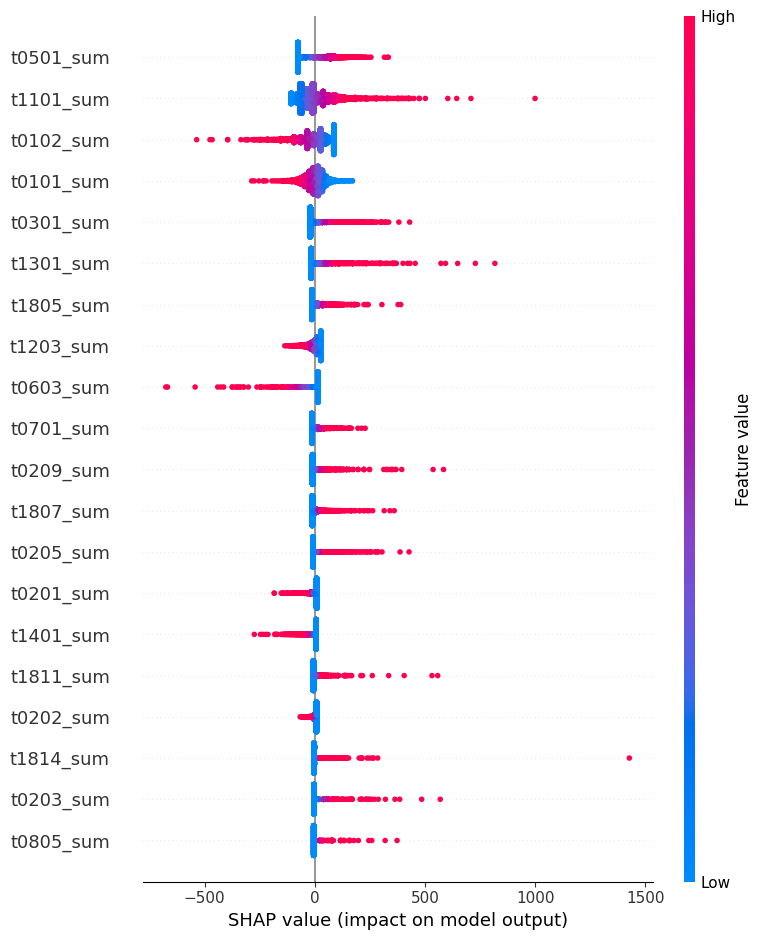

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Ridge Regressie

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 559.5230738099224
R2 Score: 0.08534667836863619
______

2022 MAE: 621.1334082425872
2022 R2 Score: -0.02530826356896232



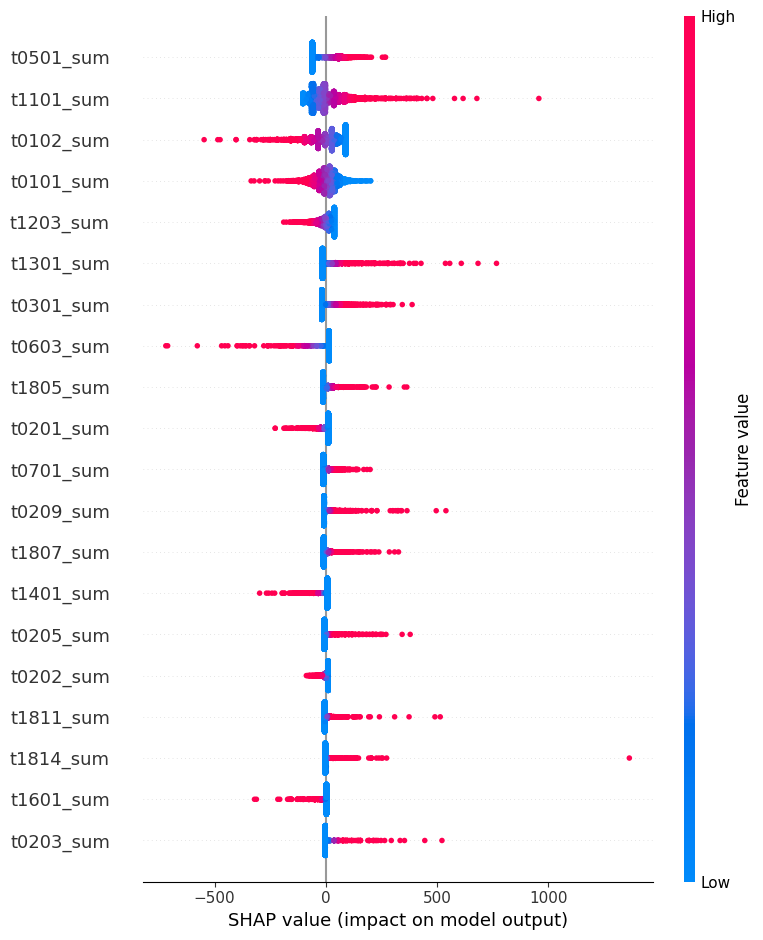

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Lasso Regressie

Beste hyperparameters: {'alpha': 1.0}

Test MAE: 559.4202856470012
R2 Score: 0.0859693129687864
______

2022 MAE: 620.8509880755342
2022 R2 Score: -0.02407861737021455



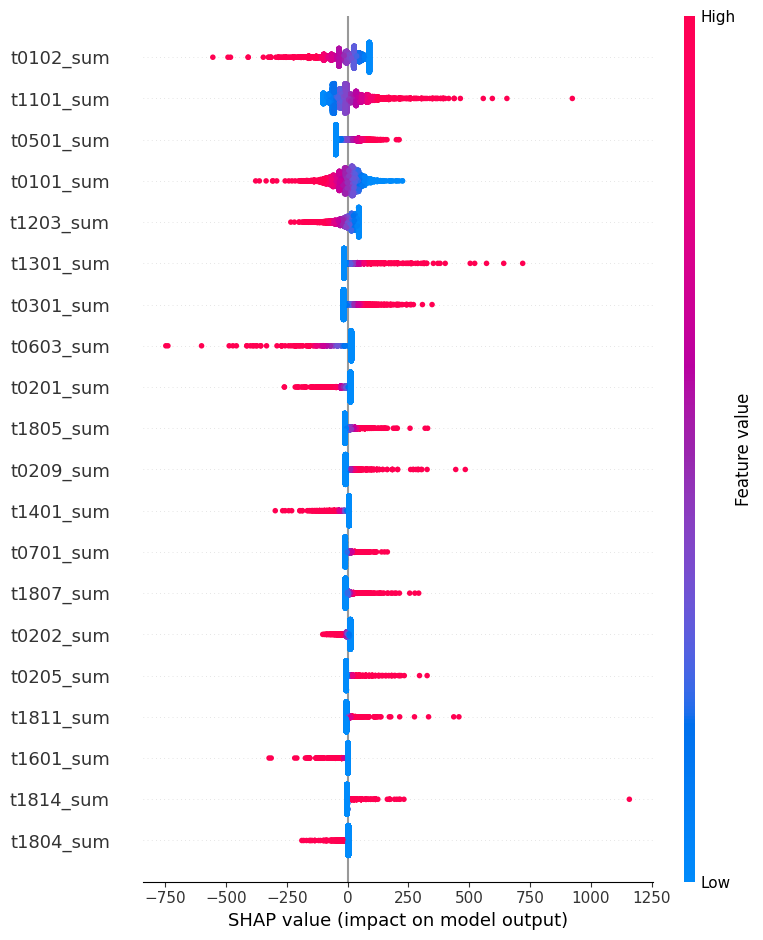

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()

param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Bayesian Ridge Regression


Test MAE: 559.9654193902926
R2 Score: 0.08556859204910805
______

2022 MAE: 621.1122470298959
2022 R2 Score: -0.025115316183268233



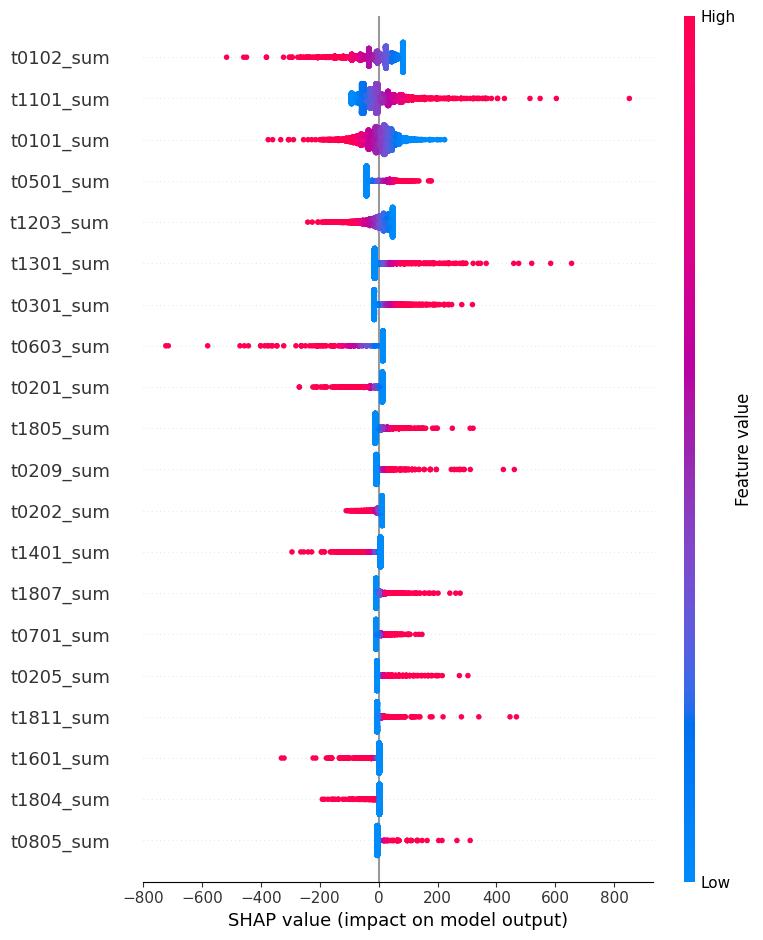

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

### Machine Learning Modellen

#### Decision Tree

Beste hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}

Test MAE: 562.0221560117509
R2 Score: 0.08028770293958132
______

2022 MAE: 624.9963282050703
2022 R2 Score: -0.027554883264050423



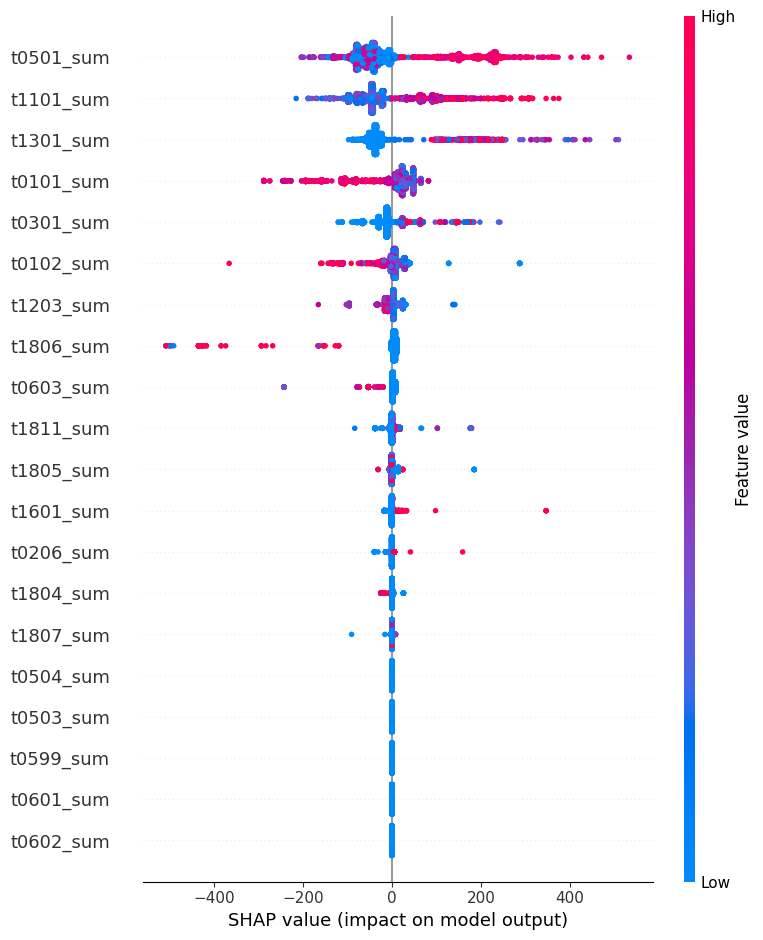

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Random Forests

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 537.1740396567182
R2 Score: 0.15408769686777368
______

2022 MAE: 598.4994288638111
2022 R2 Score: 0.04505265074178244



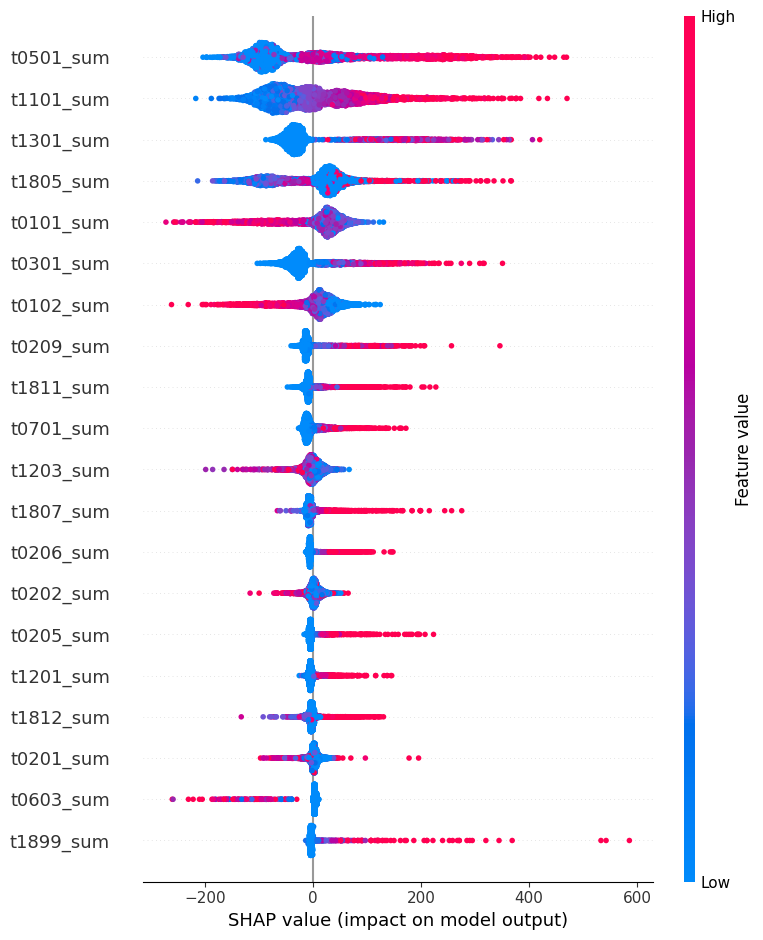

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Test MAE: 530.4633817294076
R2 Score: 0.1676273782848129
______

2022 MAE: 589.4397720261265
2022 R2 Score: 0.0711744666623767



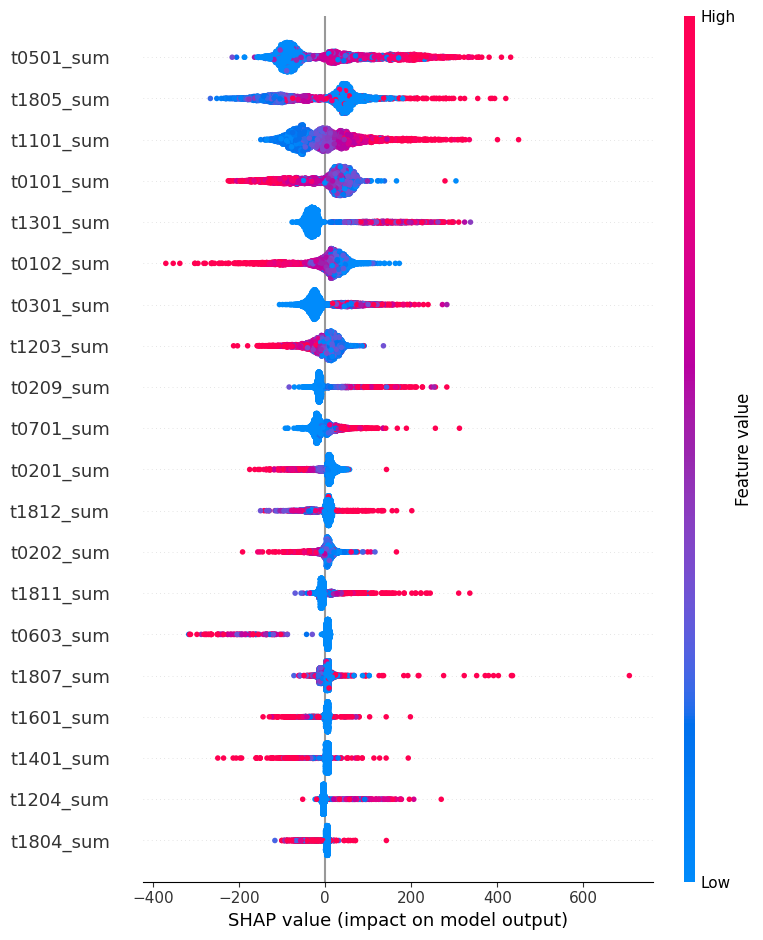

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Support Vector Machines (SVM)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}


SVR(C=100, epsilon=0.01)


Test MAE: 532.1201047926298
R2 Score: 0.060195345114510634
______

2022 MAE: 645.6228623901718
2022 R2 Score: -0.1815196816168232



  0%|          | 0/100 [00:00<?, ?it/s]

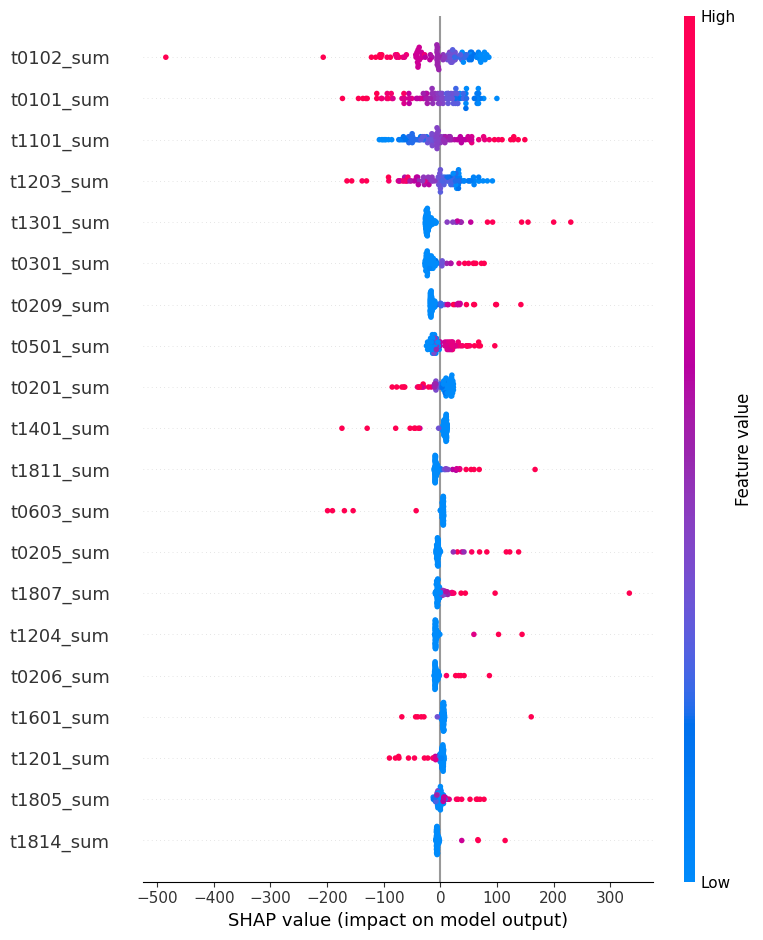

In [13]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

background = shap.kmeans(X_train_scaled, 50)  
subset_size = 100
X_test_scaled_subset, y_test_subset = shuffle(X_test_scaled, y_test, random_state=1, n_samples=subset_size)

explainer = shap.KernelExplainer(best_svr_model.predict, background)
shap_values_test = explainer.shap_values(X_test_scaled_subset)

shap.summary_plot(shap_values_test, X_test_scaled_subset, feature_names=X_train.columns)
plt.show()

#### K-Nearest Neighbors (KNN)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}


KNeighborsRegressor(n_neighbors=11)

In [17]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 573.6935595600281
R2 Score: 0.034053717968553165
______

2022 MAE: 632.4059213526654
2022 R2 Score: -0.06606795136943866



### Deep Learning Modellen

Epoch 1/100


2024-07-30 13:54:05.685204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


428/428 [==============================] - 1s 1ms/step - loss: 1301486.8750 - mae: 878.5815 - val_loss: 640028.2500 - val_mae: 577.1996
Epoch 2/100
428/428 [==============================] - 0s 859us/step - loss: 562952.9375 - mae: 573.1481 - val_loss: 536178.1875 - val_mae: 562.0031
Epoch 3/100
428/428 [==============================] - 0s 835us/step - loss: 540995.1250 - mae: 571.0383 - val_loss: 530534.3750 - val_mae: 557.6029
Epoch 4/100
428/428 [==============================] - 0s 995us/step - loss: 533863.4375 - mae: 568.4986 - val_loss: 526828.6875 - val_mae: 554.0828
Epoch 5/100
428/428 [==============================] - 0s 849us/step - loss: 528790.2500 - mae: 567.0033 - val_loss: 524025.9062 - val_mae: 553.6604
Epoch 6/100
428/428 [==============================] - 0s 858us/step - loss: 524547.8125 - mae: 564.6958 - val_loss: 520886.5000 - val_mae: 557.8467
Epoch 7/100
428/428 [==============================] - 0s 841us/step - loss: 521596.9375 - mae: 564.5004 - val_loss: 52

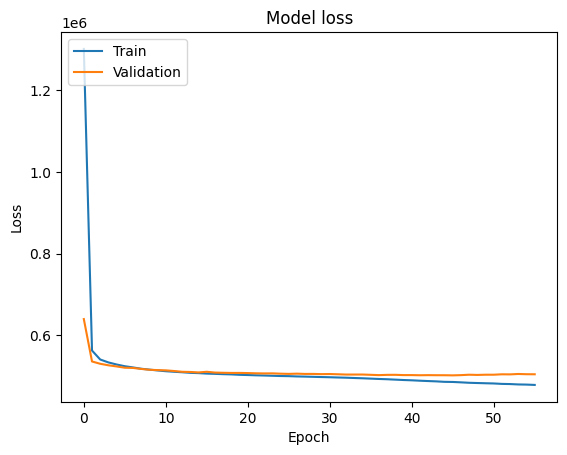

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [01:07, 53.82it/s]                       


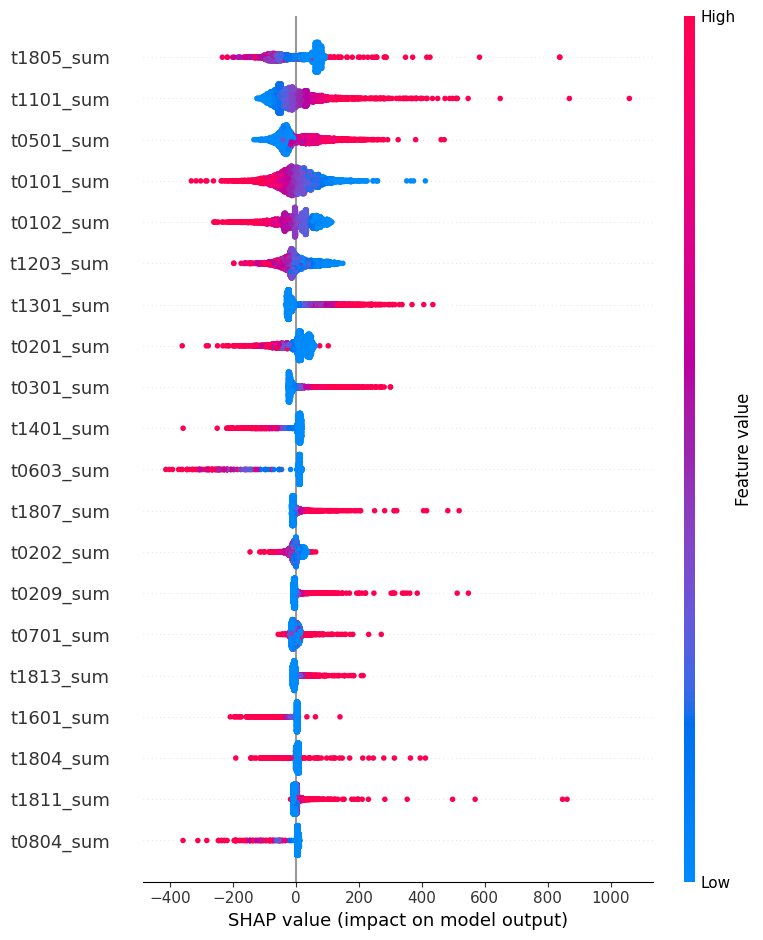

In [10]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

#### Hyperparameter Tuning: Random Search

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10,  
    executions_per_trial=2,  
    directory='my_dir',
    project_name='income_prediction3'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Trial 10 Complete [00h 00m 23s]
val_mae: 540.3017883300781

Best val_mae So Far: 535.8720092773438
Total elapsed time: 00h 04m 07s
Epoch 1/50
214/214 [==============================] - 1s 1ms/step - loss: 945861.6875 - mae: 734.3173 - val_loss: 557954.6875 - val_mae: 569.8036
Epoch 2/50
214/214 [==============================] - 0s 1ms/step - loss: 567504.7500 - mae: 576.6188 - val_loss: 539127.1875 - val_mae: 568.8401
Epoch 3/50
214/214 [==============================] - 0s 1ms/step - loss: 545652.8125 - mae: 571.3193 - val_loss: 532994.7500 - val_mae: 552.2944
Epoch 4/50
214/214 [==============================] - 0s 1ms/step - loss: 534440.2500 - mae: 567.2575 - val_loss: 524857.4375 - val_mae: 561.2545
Epoch 5/50
214/214 [==============================] - 0s 1ms/step - loss: 527236.7500 - mae: 565.2573 - val_loss: 519130.6875 - val_mae: 553.5087
Epoch 6/50
214/214 [==============================] - 0s 1ms/step - loss: 521353.7500 - mae: 562.5939 - val_loss: 517075.8750 - val_mae: 55

PermutationExplainer explainer: 4274it [01:56, 32.88it/s]                       


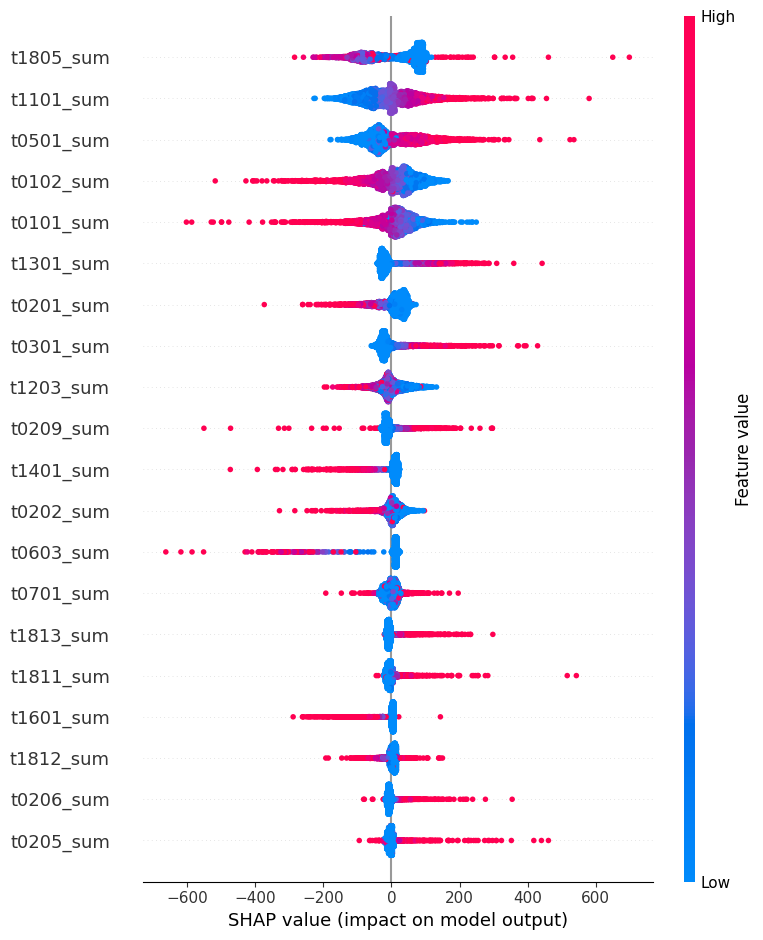

In [12]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-07-30 14:04:38,696] A new study created in memory with name: no-name-a0d8862c-02ac-4318-a3e7-3c4f5c2e9350


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:05:05,506] Trial 0 finished with value: 1004.1868559454712 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 2.3820541638222364e-05}. Best is trial 0 with value: 1004.1868559454712.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:05:37,446] Trial 1 finished with value: 1022.3660498528246 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 1.6158138494247913e-05}. Best is trial 0 with value: 1004.1868559454712.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:06:18,918] Trial 2 finished with value: 553.5225725562741 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00023715903633143287}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:06:49,091] Trial 3 finished with value: 554.190684585125 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0019665432835054347}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:07:33,326] Trial 4 finished with value: 631.800837005394 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 1.7218899022182196e-05}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:07:59,746] Trial 5 finished with value: 616.9957146701327 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0016928289037043834}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:08:30,221] Trial 6 finished with value: 983.4257540224376 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 9.088461952417893e-05}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:09:07,679] Trial 7 finished with value: 563.4038135754964 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.00015967135254231097}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:09:31,965] Trial 8 finished with value: 1042.9908633804946 and parameters: {'num_layers': 1, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 1.439839312854891e-05}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:10:04,009] Trial 9 finished with value: 917.0707346486834 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 1.5655818384310923e-05}. Best is trial 2 with value: 553.5225725562741.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:10:28,414] Trial 10 finished with value: 548.9765974893711 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.006614602917682735}. Best is trial 10 with value: 548.9765974893711.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:10:49,123] Trial 11 finished with value: 547.1211133239589 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.008735563368970418}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:11:15,753] Trial 12 finished with value: 552.4999728571925 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.008719979914450863}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:11:38,144] Trial 13 finished with value: 549.9634338785999 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.007970764488123347}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:12:15,742] Trial 14 finished with value: 553.8951437305083 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.002463427765734489}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:12:50,661] Trial 15 finished with value: 667.9184074616471 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0009061656404174907}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:13:19,927] Trial 16 finished with value: 549.4306174381683 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.004262849101465309}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:13:55,405] Trial 17 finished with value: 707.7157241973413 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00076255382261686}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:14:20,943] Trial 18 finished with value: 555.3594528803256 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.004511507283896181}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:14:58,401] Trial 19 finished with value: 699.816684277778 and parameters: {'num_layers': 3, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0006044727863177614}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 495us/step


[I 2024-07-30 14:15:04,513] Trial 20 finished with value: 550.5656539815219 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00994390659132015}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 506us/step


[I 2024-07-30 14:15:12,772] Trial 21 finished with value: 552.118149156095 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0038367370545251676}. Best is trial 11 with value: 547.1211133239589.


134/134 [==============================] - 0s 486us/step


[I 2024-07-30 14:15:21,039] Trial 22 finished with value: 543.3158612398719 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.004141802862899615}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:15:32,781] Trial 23 finished with value: 550.304785029766 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0012580590308111784}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 450us/step


[I 2024-07-30 14:15:40,919] Trial 24 finished with value: 556.6443465723012 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.004339709507736587}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 484us/step


[I 2024-07-30 14:15:50,125] Trial 25 finished with value: 544.9874373107667 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0029547328711108647}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 499us/step


[I 2024-07-30 14:16:03,094] Trial 26 finished with value: 602.4326226839494 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0004776802386174652}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 482us/step


[I 2024-07-30 14:16:13,366] Trial 27 finished with value: 552.187997330501 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.002663588232891843}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 431us/step


[I 2024-07-30 14:16:24,759] Trial 28 finished with value: 551.061692577588 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0013662519282602998}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 510us/step


[I 2024-07-30 14:16:31,848] Trial 29 finished with value: 548.7217140321667 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.003164449225148636}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 468us/step


[I 2024-07-30 14:16:38,812] Trial 30 finished with value: 548.9794590361828 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.005911076309817802}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 501us/step


[I 2024-07-30 14:16:46,864] Trial 31 finished with value: 559.201833678785 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0027452954816087134}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 501us/step


[I 2024-07-30 14:16:54,147] Trial 32 finished with value: 551.3073902549181 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0033003818671297623}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 979us/step


[I 2024-07-30 14:17:06,403] Trial 33 finished with value: 930.3499583061891 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 8.904985145550668e-05}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 470us/step


[I 2024-07-30 14:17:11,943] Trial 34 finished with value: 549.91719193944 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.005725135542796567}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 508us/step


[I 2024-07-30 14:17:24,754] Trial 35 finished with value: 562.2387102312052 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0003214098268318334}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 438us/step


[I 2024-07-30 14:17:33,489] Trial 36 finished with value: 556.3502842072036 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0019633996066303334}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 462us/step


[I 2024-07-30 14:17:43,862] Trial 37 finished with value: 570.2289223047601 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 4.556094952343063e-05}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 451us/step


[I 2024-07-30 14:17:54,608] Trial 38 finished with value: 545.640643243841 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0009412060893225756}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 435us/step


[I 2024-07-30 14:18:05,046] Trial 39 finished with value: 557.271178273407 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0011189669117237363}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 363us/step


[I 2024-07-30 14:18:12,504] Trial 40 finished with value: 560.1329536066963 and parameters: {'num_layers': 1, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0017257198954898647}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 443us/step


[I 2024-07-30 14:18:18,489] Trial 41 finished with value: 559.9072555052054 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.005592113131417144}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 446us/step


[I 2024-07-30 14:18:27,690] Trial 42 finished with value: 546.6325636713236 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.002222634942733791}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 464us/step


[I 2024-07-30 14:18:37,750] Trial 43 finished with value: 553.7183041038487 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0019041157700045738}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 373us/step


[I 2024-07-30 14:18:46,044] Trial 44 finished with value: 922.9075197236542 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00033535473743982703}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 449us/step


[I 2024-07-30 14:18:51,477] Trial 45 finished with value: 554.9850972010753 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.007079613395483052}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 411us/step


[I 2024-07-30 14:19:00,657] Trial 46 finished with value: 556.712728111326 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009105707873814946}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 445us/step


[I 2024-07-30 14:19:10,090] Trial 47 finished with value: 572.5715242443803 and parameters: {'num_layers': 1, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0023411005789343163}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 418us/step


[I 2024-07-30 14:19:19,536] Trial 48 finished with value: 914.3927248770556 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00017681527736650472}. Best is trial 22 with value: 543.3158612398719.


134/134 [==============================] - 0s 435us/step


[I 2024-07-30 14:19:28,930] Trial 49 finished with value: 570.1032390883998 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001442280536744622}. Best is trial 22 with value: 543.3158612398719.


FrozenTrial(number=22, state=TrialState.COMPLETE, values=[543.3158612398719], datetime_start=datetime.datetime(2024, 7, 30, 14, 15, 12, 773200), datetime_complete=datetime.datetime(2024, 7, 30, 14, 15, 21, 39574), params={'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.004141802862899615}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=22, value=None)
133/133 [==============================] - 0s 482us/step


Test MAE: 552.8114697879118
R2 Score: 0.08803218577359506

______
2022 MAE: 622.5871709139202
2022 R2 Score: -0.03562721580646677


PermutationExplainer explainer: 4274it [01:42, 37.42it/s]                       


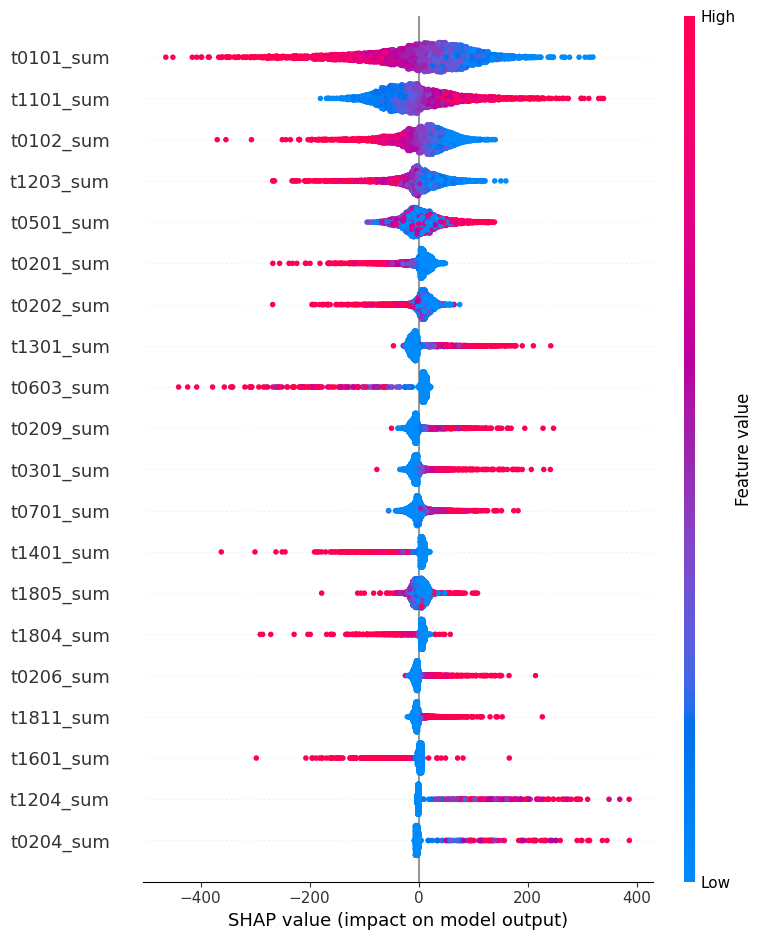

In [14]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

### 1D Convolutional Neural Network

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 1s 3ms/step - loss: 776805.8750 - mae: 671.5854 - val_loss: 543802.6250 - val_mae: 581.4987
Epoch 2/100
428/428 [==============================] - 1s 2ms/step - loss: 552375.3125 - mae: 588.2398 - val_loss: 531871.8750 - val_mae: 569.6778
Epoch 3/100
428/428 [==============================] - 1s 3ms/step - loss: 541687.6250 - mae: 582.6324 - val_loss: 520788.9688 - val_mae: 572.0124
Epoch 4/100
428/428 [==============================] - 1s 2ms/step - loss: 530214.8125 - mae: 575.8973 - val_loss: 513455.0000 - val_mae: 559.8423
Epoch 5/100
428/428 [==============================] - 1s 2ms/step - loss: 523711.6562 - mae: 571.1375 - val_loss: 512406.7812 - val_mae: 560.3605
Epoch 6/100
428/428 [==============================] - 1s 2ms/step - loss: 520745.6250 - mae: 569.8123 - val_loss: 512874.4062 - val_mae: 557.1015
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 519276.4688 - mae: 568.2785 - val_loss: 512

In [16]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-07-30 14:34:34,018] A new study created in memory with name: no-name-391ee1d1-75b2-401a-baa5-6b60cf50dae6


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:35:56,641] Trial 0 finished with value: 986.5320449731614 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.008791597998901446, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 2.2625558422523088e-05}. Best is trial 0 with value: 986.5320449731614.


134/134 [==============================] - 0s 789us/step


[I 2024-07-30 14:36:37,510] Trial 1 finished with value: 553.6289803447942 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.28873258243374494, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.00022676361612726512}. Best is trial 1 with value: 553.6289803447942.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:37:41,924] Trial 2 finished with value: 592.5589483235486 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.0014785734275906126, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.001321992086353364}. Best is trial 1 with value: 553.6289803447942.


134/134 [==============================] - 0s 902us/step


[I 2024-07-30 14:38:00,651] Trial 3 finished with value: 545.6942259488486 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.050647495134875375, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0029966012566608694}. Best is trial 3 with value: 545.6942259488486.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-30 14:43:31,256] Trial 4 finished with value: 548.0381160916953 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.47824236955674837, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0003330377224336983}. Best is trial 3 with value: 545.6942259488486.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:44:43,151] Trial 5 finished with value: 592.9220948111233 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.39866523054483666, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0033149610915513975}. Best is trial 3 with value: 545.6942259488486.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 14:47:31,892] Trial 6 finished with value: 577.5565183387148 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4856961044927854, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 3.856091599718513e-05}. Best is trial 3 with value: 545.6942259488486.


134/134 [==============================] - 0s 689us/step


[I 2024-07-30 14:47:45,665] Trial 7 finished with value: 558.4112026430057 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.31854597136483515, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.00089401894666467}. Best is trial 3 with value: 545.6942259488486.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:48:20,480] Trial 8 finished with value: 545.6319048992276 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.09103898040450659, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0023016447780680083}. Best is trial 8 with value: 545.6319048992276.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:49:31,565] Trial 9 finished with value: 556.0761664095289 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.41092139250666404, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.00015085490707033607}. Best is trial 8 with value: 545.6319048992276.


134/134 [==============================] - 0s 803us/step


[I 2024-07-30 14:50:17,292] Trial 10 finished with value: 592.2458835662335 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.18926128557232408, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.005860825971833273}. Best is trial 8 with value: 545.6319048992276.


134/134 [==============================] - 0s 895us/step


[I 2024-07-30 14:50:45,487] Trial 11 finished with value: 543.7004060543032 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.12205265498885856, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.009009988627139575}. Best is trial 11 with value: 543.7004060543032.


134/134 [==============================] - 0s 980us/step


[I 2024-07-30 14:51:12,311] Trial 12 finished with value: 531.8772353838156 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.12386490293539072, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.009100528466866268}. Best is trial 12 with value: 531.8772353838156.


134/134 [==============================] - 0s 873us/step


[I 2024-07-30 14:51:44,525] Trial 13 finished with value: 531.2554171050518 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.15935544874768642, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.006407042821284376}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 851us/step


[I 2024-07-30 14:52:10,198] Trial 14 finished with value: 544.6168392425116 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.18929030415436396, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.009760447807364162}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 14:54:06,863] Trial 15 finished with value: 533.0344657921607 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.17326870416930923, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0007058312964884863}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:54:58,216] Trial 16 finished with value: 534.5805536659647 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.23621369869950223, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.004338285165258519}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:55:59,622] Trial 17 finished with value: 583.0916783659526 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.12207872046726274, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.00010121594566966791}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 14:57:14,965] Trial 18 finished with value: 592.2683569878726 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.25431866113087004, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001543666832763794}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 15:00:05,820] Trial 19 finished with value: 535.8425666077388 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.07519877875581099, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0005926241812456622}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:00:56,701] Trial 20 finished with value: 567.1504613340786 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.15560387968428785, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 6.501290757275991e-05}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:02:24,905] Trial 21 finished with value: 558.6896335410938 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.16428114841181787, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0004970024454733872}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 15:06:26,786] Trial 22 finished with value: 593.8722110318881 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.21300022125296073, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 1.1099389774077387e-05}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:07:26,290] Trial 23 finished with value: 536.3899536282794 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.14135638875306666, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.004903701585342936}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:07:45,727] Trial 24 finished with value: 557.4530490884998 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.27011487278774693, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0016987853553535467}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:08:52,244] Trial 25 finished with value: 535.8391379053788 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.09056871701773618, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.006745222886652219}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:09:31,452] Trial 26 finished with value: 750.2386647553268 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.04216291317288928, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0009218694793964112}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 15:12:29,720] Trial 27 finished with value: 534.8779412307579 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3097215271282443, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002668621685960479}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:13:37,112] Trial 28 finished with value: 535.7978672648046 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2142845470635219, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.005997202317681226}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:15:30,010] Trial 29 finished with value: 591.9614423117357 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.12268078495736215, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0009532963818123784}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:16:11,797] Trial 30 finished with value: 555.191558895312 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.180314652833279, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.00044234893643507235}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:16:29,709] Trial 31 finished with value: 553.7959169803931 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20581293868520895, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.004343249667997527}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:16:45,806] Trial 32 finished with value: 549.6085464353208 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.23474942872497478, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0038531179997353606}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:17:15,530] Trial 33 finished with value: 542.4396446486923 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2351710581872829, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.008343355213807208}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:18:04,719] Trial 34 finished with value: 544.8561816824769 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3504357469824091, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.002175986760223529}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:19:28,579] Trial 35 finished with value: 554.419621485954 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.033503571057573345, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00018156901983937916}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:20:11,348] Trial 36 finished with value: 592.5537720052235 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.28243203534873296, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.004049312974315172}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:20:45,390] Trial 37 finished with value: 561.0376101479061 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.14935409427858543, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0012870103140170904}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 15:21:59,446] Trial 38 finished with value: 550.8463771351021 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.08418939986045787, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0003254221643133802}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 15:24:22,740] Trial 39 finished with value: 541.318587867028 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.018722253829459162, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.002893542994264368}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:25:31,297] Trial 40 finished with value: 592.9586420570479 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.06349184389872282, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0068903810363794}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 15:30:36,829] Trial 41 finished with value: 537.7215755650659 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.31481840873032246, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002532900584880132}. Best is trial 13 with value: 531.2554171050518.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 15:39:08,313] Trial 42 finished with value: 530.5213890272445 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.36864717353605725, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002093241216786228}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 15:48:06,496] Trial 43 finished with value: 541.0930015636455 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4311770593768654, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0006613094991291634}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 15:53:43,406] Trial 44 finished with value: 546.7034919462733 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3453191722031378, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0019568704518595492}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:55:11,509] Trial 45 finished with value: 542.0127779995315 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.11451078525218025, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.0011448859345032278}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 15:57:39,262] Trial 46 finished with value: 534.6627096550833 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4463109094077525, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.00337945058574387}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 16:02:50,287] Trial 47 finished with value: 539.86166874139 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3844553403589268, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.005007244150307633}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:03:54,452] Trial 48 finished with value: 541.7328176993083 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2488015821727751, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00965999284155737}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 16:04:59,586] Trial 49 finished with value: 544.8836909988728 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.1636587948601093, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.006376725539584819}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 16:09:36,333] Trial 50 finished with value: 574.3883628711303 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.19040599288507362, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0007140565343151886}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 16:12:05,350] Trial 51 finished with value: 539.2150100413 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.45998075539498084, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0050449022664493595}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 16:14:57,418] Trial 52 finished with value: 536.7238057602505 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.46195390228073735, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.003268916163109618}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 16:16:55,324] Trial 53 finished with value: 542.5367043366758 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4266224332369798, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0031499587059321656}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 16:17:59,137] Trial 54 finished with value: 565.8393268584134 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.49601440502258887, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0015577552468972317}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 16:19:52,308] Trial 55 finished with value: 561.1294070670968 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3680001475750632, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.007636087165536777}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:21:41,188] Trial 56 finished with value: 555.6828595789556 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.10654888879533332, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0002289340063858381}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 16:24:12,577] Trial 57 finished with value: 534.449039773296 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1704144135840338, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0021105520143719974}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 16:24:46,654] Trial 58 finished with value: 549.6251063607745 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17568712433942316, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0023459297875376255}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 16:26:35,658] Trial 59 finished with value: 542.9934927720262 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.19814641689046741, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001974442234512005}. Best is trial 42 with value: 530.5213890272445.


134/134 [==============================] - 1s 8ms/step


[I 2024-07-30 16:33:13,349] Trial 60 finished with value: 522.1693863523533 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.13896883310071217, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00043250033752102344}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 16:39:52,127] Trial 61 finished with value: 558.0759566673673 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.13479777637391227, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00039434268848295657}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 8ms/step


[I 2024-07-30 16:43:42,801] Trial 62 finished with value: 549.5364782544865 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.13571020895880614, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0005885253001786752}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 16:49:23,153] Trial 63 finished with value: 550.2016352128971 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.21720366850090822, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00013183250120410702}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 16:56:43,006] Trial 64 finished with value: 547.8771869399278 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17109265696758322, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00025951114182691076}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 8ms/step


[I 2024-07-30 17:02:00,564] Trial 65 finished with value: 537.2571103655537 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.10370339664009931, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0011406581298859686}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:03:02,349] Trial 66 finished with value: 592.8838719274734 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.15119241305705428, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.004719930219368833}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:06:53,427] Trial 67 finished with value: 534.2936638048039 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.22798740661362013, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.000831328609378986}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:09:21,425] Trial 68 finished with value: 561.1693208424224 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2257628941331225, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.00047395521836789486}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 17:15:32,419] Trial 69 finished with value: 544.6040992003695 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.25551747717204754, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0008873206870856758}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:18:29,995] Trial 70 finished with value: 549.4841643867876 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2967819908336484, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007037804537479618}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:21:44,950] Trial 71 finished with value: 553.9682709907676 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2678310439180138, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00037642726133426486}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:24:20,477] Trial 72 finished with value: 544.8566459127793 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1855463548857833, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001641350535723789}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:25:17,051] Trial 73 finished with value: 530.7447459474827 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1596178041753186, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.005691670581898297}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:26:39,949] Trial 74 finished with value: 555.0026501863365 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16074814973178517, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0002847479705384971}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:31:20,222] Trial 75 finished with value: 586.3590486348922 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.12513570606993474, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 3.6318987381004575e-05}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:32:09,584] Trial 76 finished with value: 542.9821756046437 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1487114840125655, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.008035484131765455}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:34:26,380] Trial 77 finished with value: 545.2126932770425 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20065259875640346, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.005652588884342878}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:36:41,623] Trial 78 finished with value: 592.3138932139304 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.060039162890914266, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.001344283416427509}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:40:31,426] Trial 79 finished with value: 531.5913761997647 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.09917380676113617, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0005323829456940691}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 17:46:39,888] Trial 80 finished with value: 544.5471393250782 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.0936788158449291, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0005636558621897562}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:48:38,045] Trial 81 finished with value: 554.8817814995693 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.0769582555650364, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0009344514381231409}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:49:47,262] Trial 82 finished with value: 555.4221502086872 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.12998959754891917, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00974947072609676}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:51:47,416] Trial 83 finished with value: 547.2897389054783 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.11026242254871527, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0008315400114178732}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:53:21,442] Trial 84 finished with value: 537.7439692924745 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.14551914861994722, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.003665567075923465}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 17:56:08,969] Trial 85 finished with value: 541.878479691748 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.17485411092822756, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0011405455008074573}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 18:00:17,337] Trial 86 finished with value: 541.4138739935698 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16245182671422817, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0004788827028326836}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:00:54,291] Trial 87 finished with value: 557.3094259202808 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.09869183039639036, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0007756932246987071}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 18:05:45,765] Trial 88 finished with value: 566.1381876158855 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.19248638792168438, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.0003661975156902601}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:06:31,349] Trial 89 finished with value: 592.6705210462588 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.12223842709720882, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.006753276219751868}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 18:09:43,394] Trial 90 finished with value: 534.9427486839088 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.32919690205554714, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012837550614607813}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:10:17,330] Trial 91 finished with value: 548.8303446300175 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.23368231284372518, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.003981001260294798}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:10:42,753] Trial 92 finished with value: 543.4572904035763 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20910922611443208, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.005599330766383263}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:11:23,019] Trial 93 finished with value: 536.9736546989527 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2239929103617809, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0028059486854677337}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:12:05,218] Trial 94 finished with value: 535.8870280898986 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2514093740306069, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.007876015378229425}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:12:19,287] Trial 95 finished with value: 560.5319348387983 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1397072381723186, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0020874927924715526}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:12:56,427] Trial 96 finished with value: 551.4332761348953 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.18240734036249295, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0005485355320149047}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 18:18:24,995] Trial 97 finished with value: 591.969875569414 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16409634225885913, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 1.0252690858355472e-05}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 18:19:42,664] Trial 98 finished with value: 541.3402862111785 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.11607874831452847, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.007046310459746824}. Best is trial 60 with value: 522.1693863523533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:20:49,031] Trial 99 finished with value: 531.8327920951816 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.28226379156002535, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00441749890436972}. Best is trial 60 with value: 522.1693863523533.


FrozenTrial(number=60, state=TrialState.COMPLETE, values=[522.1693863523533], datetime_start=datetime.datetime(2024, 7, 30, 16, 26, 35, 659456), datetime_complete=datetime.datetime(2024, 7, 30, 16, 33, 13, 348744), params={'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.13896883310071217, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00043250033752102344}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDist

In [17]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 1s 8ms/step


Test MAE: 533.8323352762833
R2 Score: 0.14017333512516872

______
2022 MAE: 599.8203387330213
2022 R2 Score: 0.026139784812735378


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


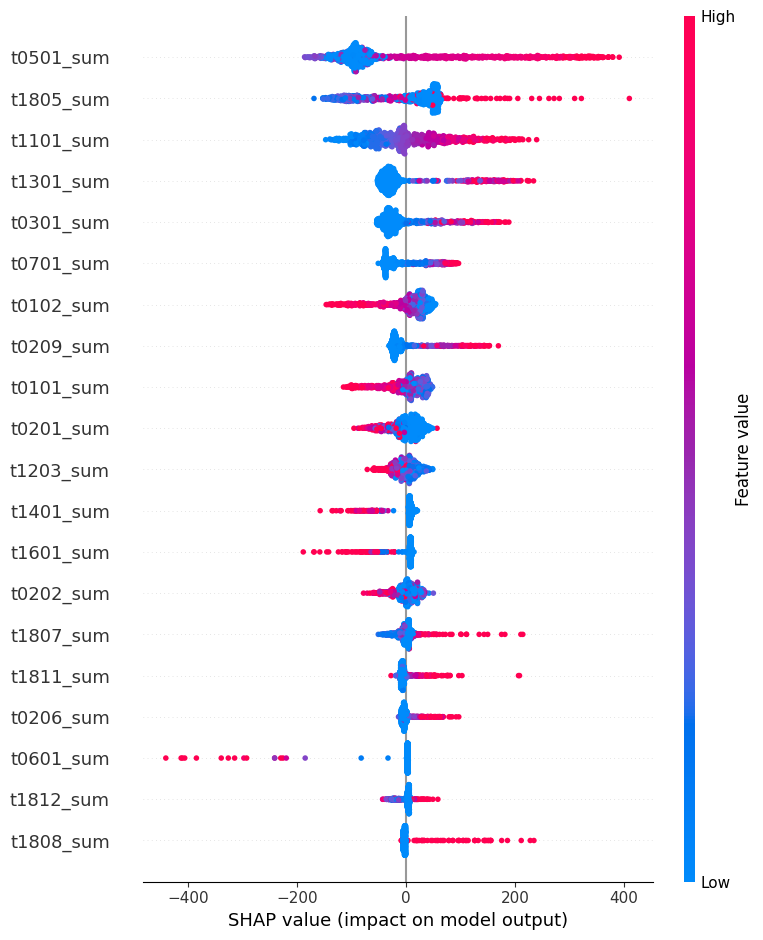

In [18]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(best_model, background)

X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)